# <span style = "background-color: #FFDDDD"> 직접 만들어보는 OCR</span>

⭐️ Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다. 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.  
⭐️ 2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다. 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.  
⭐️ 3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다. 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

---
## <span style = "background-color: #FFFFDD"> 🐶 Environment Settings</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# useful tools
import re
import six
import math
import lmdb
import os

In [2]:
# data array
import numpy as np

In [42]:
# image data handling
from IPython.display import display
from PIL import Image
from PIL import ImageDraw
import cv2

In [4]:
# visualization
import matplotlib.pyplot as plt

In [5]:
# machine learning
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

import keras_ocr
from keras_ocr.detection import Detector

In [6]:
# load dataset
import lmdb

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [7]:
DATA_PATH = os.getenv("HOME") + "/aiffel/ocr"

TRAIN_DATA_PATH = DATA_PATH + "/data/MJ/MJ_train"
VALID_DATA_PATH = DATA_PATH + "/data/MJ/MJ_valid"
TEST_DATA_PATH = DATA_PATH + "/data/sample.jpg"

In [8]:
NUM_CHAR = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

TARGET_CHARACTERS = ENG_CHAR_UPPER + NUM_CHAR

In [9]:
# model training configurations
BATCH_SIZE = 128
EPOCHS =30

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [10]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

### <span style = "background-color: #F0E9FF"> 4. Check GPU settings</span>

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## <span style = "background-color: #FFFFDD"> 🐶 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

In [12]:
# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

### <span style = "background-color: #F0E9FF"> 2. Preview dataset</span>

--------------------------------------------------------------------------------
> Original image size : width 72, height 31
> Target image size : (74, 32)
> Display image shape : (74, 32, 3)
> Label : Lube
> Preview : 


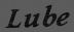

--------------------------------------------------------------------------------
> Original image size : width 82, height 31
> Target image size : (84, 32)
> Display image shape : (84, 32, 3)
> Label : Spencerian
> Preview : 


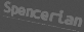

--------------------------------------------------------------------------------
> Original image size : width 115, height 31
> Target image size : (100, 32)
> Display image shape : (100, 32, 3)
> Label : accommodatingly
> Preview : 


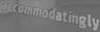

--------------------------------------------------------------------------------
> Original image size : width 140, height 31
> Target image size : (100, 32)
> Display image shape : (100, 32, 3)
> Label : CARPENTER
> Preview : 


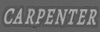

In [13]:
# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        
        print_single_divider()
        
        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print("> Original image size : width {}, height {}".format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print("> Target image size : {}".format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print("> Display image shape : {}".format(img.shape))
        print("> Label : {}".format(label))
        print("> Preview : ")
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

### <span style = "background-color: #F0E9FF"> 3. Pre-process data</span>

**3-1. Define dataset transfer methods/classes**

In [14]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

**3-2. Define TEXT -> NUMBER label encoding methods**

In [15]:
class LabelConverter(object):
    
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
            
    def encode(self, text):
        encoded_label = []
        # [[YOUR CODE]]
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [16]:
label_converter = LabelConverter(TARGET_CHARACTERS)

### <span style = "background-color: #F0E9FF"> 4. Prepare final train-ready data</span>

**4-1. Prepare training data**

In [17]:
train_data = MJDatasetSequence(TRAIN_DATA_PATH,
                               label_converter,
                               batch_size=BATCH_SIZE,
                               character=TARGET_CHARACTERS,
                               is_train=True)

**4-2. Prepare validation data**

In [18]:
val_data = MJDatasetSequence(VALID_DATA_PATH,
                             label_converter,
                             batch_size=BATCH_SIZE,
                             character=TARGET_CHARACTERS)

---
## <span style = "background-color: #FFFFDD"> 🐶 Model Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Prepare text detection model</span>

In [19]:
# load pre-trained model (keras_ocr.detection.Detector)
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


### <span style = "background-color: #F0E9FF"> 2. Prepare text recognition model</span>

**2-1. Define CRNN model structure**

In [20]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

**2-2. Define model optimizing options**

In [21]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [22]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)

**2-3. Train the model and save by epochs**

In [23]:
# list to save history by each 10 epochs
loss_per_epoch = []
val_loss_per_epoch = []

In [25]:
for i in range(0, EPOCHS, 10):
    # prepare model to train
    model = build_crnn_model()
    
    if i != 0:    # load previously trained model
        model.load_weights("crnn_epochs_" + str(i))

        
    # train the model
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                  optimizer=optimizer)
    
    history = model.fit(train_data,
                        steps_per_epoch=len(train_data),
                        epochs=10,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                       )
    
    # save the model
    loss_per_epoch.extend(history.history["loss"])
    val_loss_per_epoch.extend(history.history["val_loss"])
    
    model.save_weights("crnn_epochs_" + str(i+10))
    print("> Model training finished & saved successfully!")

Epoch 1/10
565/565 [==============================] - 89s 147ms/step - loss: 25.2610 - val_loss: 24.5317
Epoch 2/10
565/565 [==============================] - 82s 145ms/step - loss: 14.6838 - val_loss: 9.4169
Epoch 3/10
565/565 [==============================] - 82s 145ms/step - loss: 7.1816 - val_loss: 6.9218
Epoch 4/10
565/565 [==============================] - 82s 145ms/step - loss: 5.1789 - val_loss: 5.2361
Epoch 5/10
565/565 [==============================] - 82s 145ms/step - loss: 4.1263 - val_loss: 4.9019
Epoch 6/10
565/565 [==============================] - 82s 145ms/step - loss: 3.3867 - val_loss: 4.7164
Epoch 7/10
565/565 [==============================] - 82s 144ms/step - loss: 2.7998 - val_loss: 4.1798
Epoch 8/10
565/565 [==============================] - 82s 144ms/step - loss: 2.3088 - val_loss: 4.1942
Epoch 9/10
565/565 [==============================] - 81s 144ms/step - loss: 1.8961 - val_loss: 4.2027
Epoch 10/10
565/565 [==============================] - 82s 145ms/step 

**2-4. Visualize model training performance**

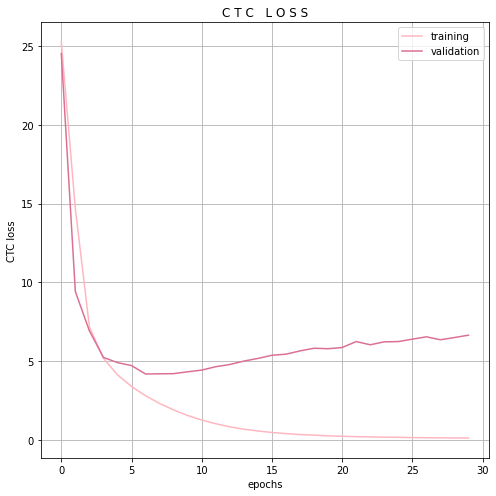

In [31]:
fig = plt.figure(figsize=(7,7))

loss_graph = fig.add_subplot(1, 1, 1)
loss_graph.plot(loss_per_epoch, color="lightpink", label="training")
loss_graph.plot(val_loss_per_epoch, color="palevioletred", label="validation")
loss_graph.set_title("C T C   L O S S")
loss_graph.set_xlabel("epochs")
loss_graph.set_ylabel("CTC loss")
loss_graph.grid()
loss_graph.legend()

plt.tight_layout()
plt.show()

---
## <span style = "background-color: #FFFFDD"> 🐶 Experiments</span>

### <span style = "background-color: #F0E9FF"> 1. Prepare inference models</span>

In [32]:
rcnn_trained_10 = build_crnn_model()
rcnn_trained_10.load_weights("crnn_epochs_10")
rcnn_trained_10_pred = Model(inputs=rcnn_trained_10.get_layer("input_image").output,
                            outputs=rcnn_trained_10.get_layer("output").output)

In [33]:
rcnn_trained_20 = build_crnn_model()
rcnn_trained_20.load_weights("crnn_epochs_20")
rcnn_trained_20_pred = Model(inputs=rcnn_trained_20.get_layer("input_image").output,
                            outputs=rcnn_trained_20.get_layer("output").output)

In [34]:
rcnn_trained_30 = build_crnn_model()
rcnn_trained_30.load_weights("crnn_epochs_30")
rcnn_trained_30_pred = Model(inputs=rcnn_trained_30.get_layer("input_image").output,
                            outputs=rcnn_trained_30.get_layer("output").output)

In [ ]:
#rcnn_trained_40 = build_crnn_model()
#rcnn_trained_40.load_weights("crnn_epochs_40")
#rcnn_trained_40_pred = Model(inputs=rcnn_trained_40.get_layer("input_image").output,
#                            outputs=rcnn_trained_40.get_layer("output").output)

In [ ]:
#rcnn_trained_50 = build_crnn_model()
#rcnn_trained_50.load_weights("crnn_epochs_50")
#rcnn_trained_50_pred = Model(inputs=rcnn_trained_50.get_layer("input_image").output,
#                            outputs=rcnn_trained_50.get_layer("output").output)

In [35]:
rcnn_preds = [rcnn_trained_10_pred,
              rcnn_trained_20_pred,
              rcnn_trained_30_pred,
              #rcnn_trained_40_pred,
              #rcnn_trained_50_pred,
             ]

### <span style = "background-color: #F0E9FF"> 2. Define experimental methods</span>

**2-1. Define text detection experimental methods**

In [76]:
def detect_text(img_path):

    # Load the image
    img = keras_ocr.tools.read(img_path)

    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = detector.detect(images=[img])[0]

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    result_img = Image.fromarray(img)
    img_draw = ImageDraw.Draw(result_img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(Image.fromarray(img).crop(word_box))
        #cropped_imgs.append(img_result.crop(word_box))

    return result_img, cropped_imgs

**2-2. Define text recognition experimental methods**

In [54]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [64]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    img_arr = np.array(pil_img)
    img_arr = cv2.resize(img_arr, (input_img_size[1], input_img_size[0]))
    img_arr = np.expand_dims(img_arr, axis=0)
    
    results = []
    for model in rcnn_preds:
        prediction = model.predict(np.array(img_arr))
        decoded_result = decode_predict_ctc(prediction, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        results.append(decoded_result)
        
    print("> Recognized text by 10-epoch-trained model : \t", results[0])
    print("> Recognized text by 20-epoch-trained model : \t", results[1])
    print("> Recognized text by 30-epoch-trained model : \t", results[2])

### <span style = "background-color: #F0E9FF"> 3. Prepare test data samples</span>

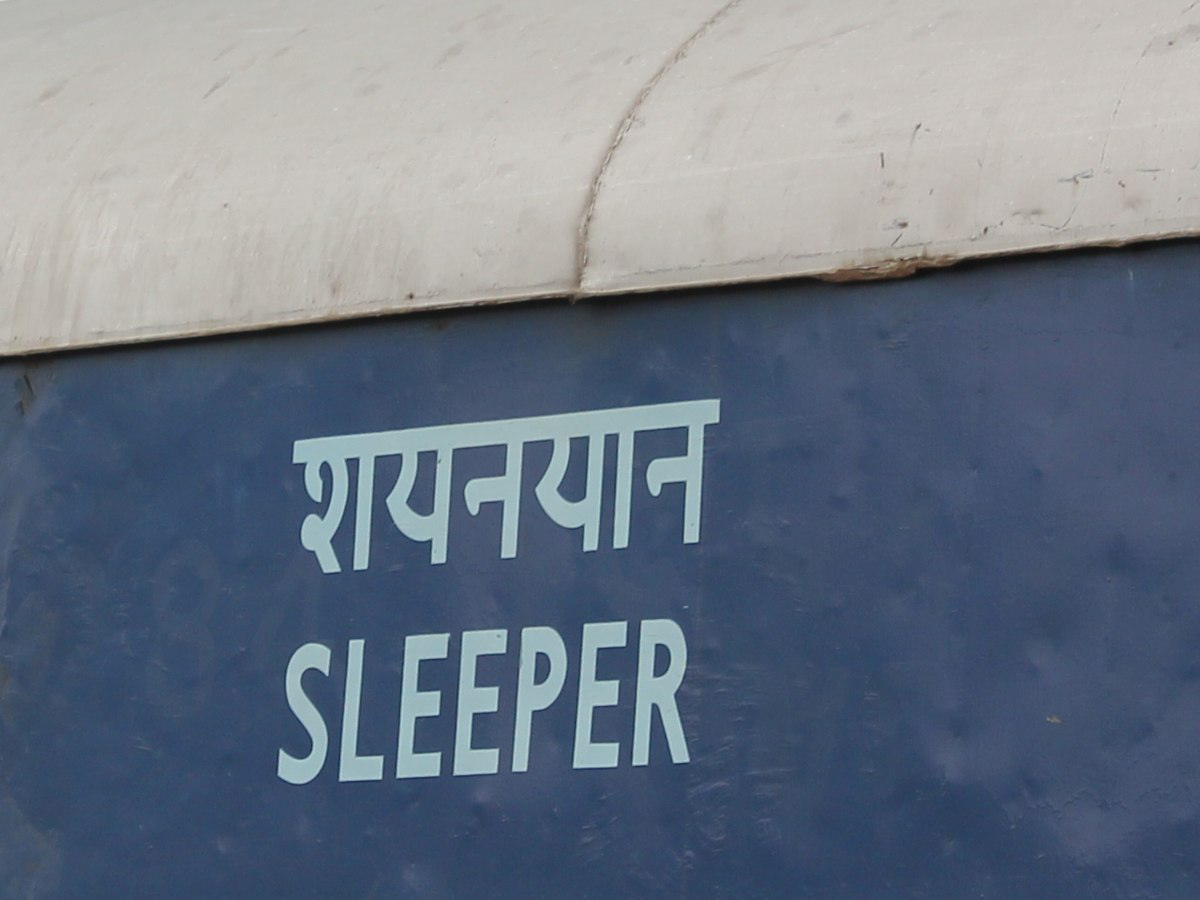

In [79]:
test_sample_img = Image.open(TEST_DATA_PATH)
display(test_sample_img)

### <span style = "background-color: #F0E9FF"> 3. Experiment with various models</span>

In [80]:
detected_img, cropped_img_list = detect_text(TEST_DATA_PATH)

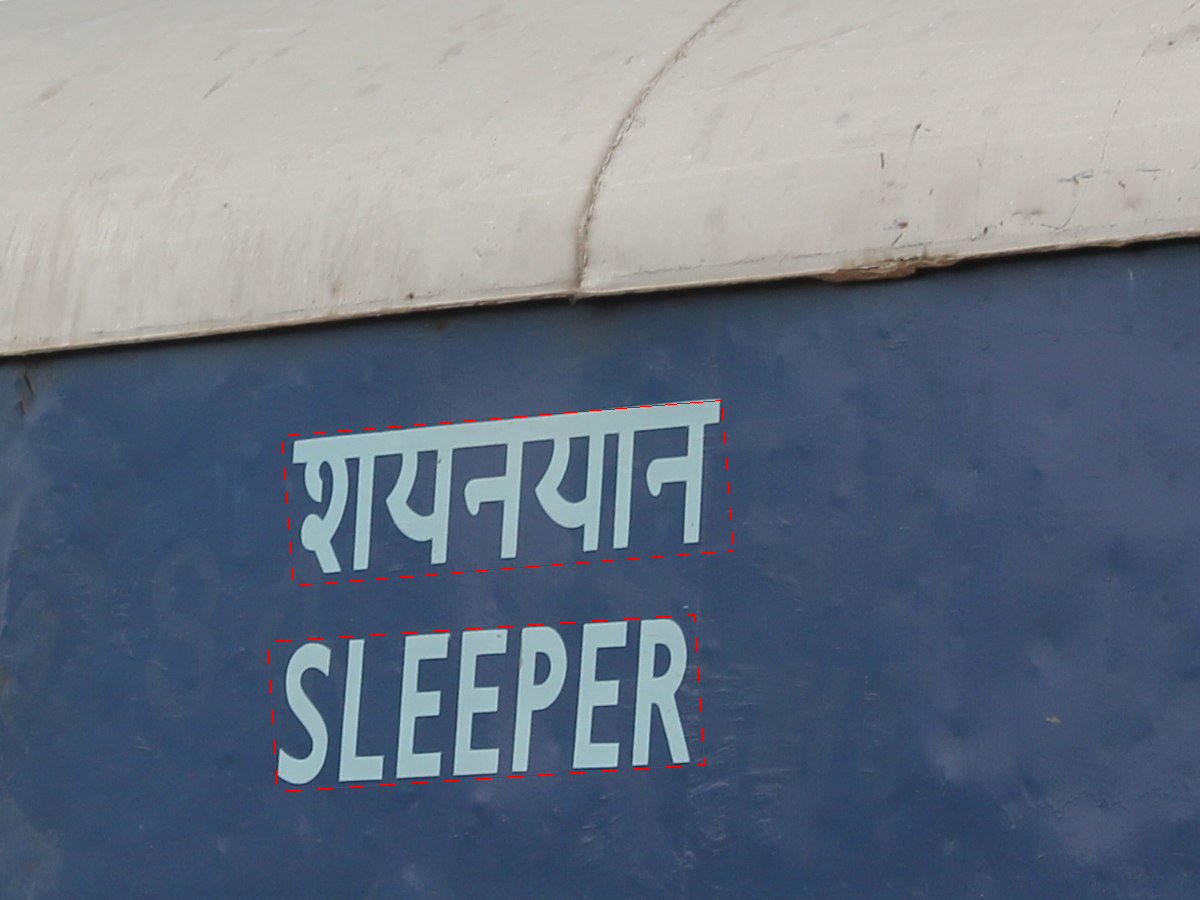

In [81]:
display(detected_img)

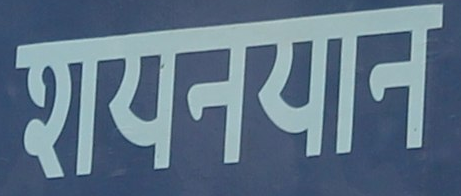

> Recognized text by 10-epoch-trained model : 	 NS999999999999999999999
> Recognized text by 20-epoch-trained model : 	 JST999999999999999999999
> Recognized text by 30-epoch-trained model : 	 ST9999999999999999999999


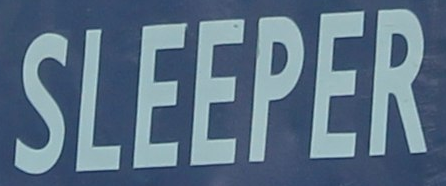

> Recognized text by 10-epoch-trained model : 	 ESOSE9999999999999999999
> Recognized text by 20-epoch-trained model : 	 EIE999999999999999999999
> Recognized text by 30-epoch-trained model : 	 ES9999999999999999999999


In [82]:
for _img in cropped_img_list:
    # display text-detected region
    display(_img)
    
    # prediction(recognition) result 
    recognize_img(_img)

---
## <span style = "background-color: #FFFFDD"> 🐶 Appendix : Additional Experiments</span>

**여기에 추후 광석 퍼실넴 미션 (테서렉트, GCP)**

---
## <span style = "background-color: #FFFFDD"> 🐶 Conclusion</span>

**📝 실험결과 분석**
- 테스트 결과 정확도는 엉망이였다!😆 완전히 엉망이라기에는 얼추 비슷하게 생긴 문자끼리 혼동을 하는 듯 했다.
- 비록 텍스트 인식 정확도는 떨어지지만, 학습 epoch 수에 따라 인식 성능이 달라지는 것을 체감할 수 있었다. 학습 epoch 수가 적을수록 텍스트 문자의 길이는 얼추 비슷하게 유추하는 듯 했다. 반면 학습 epoch 수가 많을수록 문자 자체를 인식을 못하는건지, 인식 결과의 길이가 점점 짧아졌다. SLEEPER는 총 7개의 문자인데, epoch 10만큼 학습한 모델은 5개의 문자를, epoch 20만큼 학습한 모델은 3개의 문자를, epoch 30만큼 학습한 모델은 2개의 문자를 인식하였다.
- 일반적으로는 학습 epoch 수가 많을수록 좋은 성능을 보이는데 CRNN의 경우 그렇지 않았다. 특히 CTC loss 그래프에 의하면 epoch=5 전후로 성능이 가장 좋았을 것으로 유추되는데, epoch=5 지점에서 모델을 저장하고 예측하였다면 더 나은 인식 결과가 나왔을지도 모르겠다.

**📝 회고록**  
- 문자를 인식하고 남은 길이만큼 "9"로 채워져있는데, 실전에서는 어떻게 후처리를 하면 좋을까? 단순하게 rstrip("9")를 적용한다면, 실제로 "9"로 이루어진 이미지를 인식할 때 혼동이 일어날 것이다. -> 퍼실님께 질문한 결과 endtoken 부분을 조정해볼 것을 조언해주셨다. 
- 다른 그루들이 실험해보는 것을 옆에서 기웃거린 결과, 이번 실험에서 사용한 CRNN 외의 다른 모델의 경우 input image 의 전처리 상태에 따라 성능이 달라지는 듯 했다. 예를 들어 CRNN의 경우 원본 이미지로부터 텍스트 영역이 감지된만큼 crop한 후 해당 부분을 입력해야 최적의 성능이 나오지만, 다른 모델의 경우 자르지 않고 원본 이미지 그대로 입력해야 최적의 성능이 나오는 듯 했다 (그 모델은 아마 "이미지 속 텍스트"라는 사실을 의식하여, 텍스트 주변에 여백 픽셀들이 많을 것이라는 점을 학습했을 것이다)
- 방학동안 푹 쉬고 오랜만에 노드 하려니 몸과 머리가 따라주지 않아 영 힘들었다 😗

---